In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings,AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR
from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt
from pysindy import EnsembleOptimizer
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'serif'
import matplotlib as mpl
# mpl.rcParams.update({"text.usetex":True})
import dill

save_path = 'data.pkl'

/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/sympy2jax/sympy_module.py:291: UserWarning: `equinox.static_field` is deprecated in favour of `equinox.field(static=True)`
  has_extra_funcs: bool = eqx.static_field()


In [3]:
exp_data = LorenzExp
initial_state = jnp.array([ -8,8,27.])
dt = 0.025
t_train = jnp.arange(0,10.01,dt)
noise_var = 0.1
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 505
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=29,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

lorenz_sol = expdata.system_sol
t_train = expdata.t_train

In [4]:
true_sigma2 = 0.05
x_vals = jax.vmap(lorenz_sol.evaluate)(t_train)
x_train = x_vals + (
    jnp.sqrt(true_sigma2) * 
    jax.random.normal(jax.random.PRNGKey(32),(len(t_train),3))
)

measurement_vecs = jnp.tile(jnp.eye(3)[:2,:],(int(len(t_train)/2+1),1))[:len(t_train)]
y_obs = jnp.sum(measurement_vecs*x_train,axis=1)

In [5]:
n_colloc = 500
trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
colloc_weight = 1e5
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.1,alpha = 0.01)
    )

In [6]:
optimizer = AnnealedAlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y','z']
)

model.fit(
    t_train,
    t_colloc = None,
    w_colloc = None,
    partialobs_v = measurement_vecs,
    partialobs_y = y_obs,
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


{'show_progress': True, 'sigma2_est': Array(0.05778464, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 100000.0}
Solving for data_weight = 1.0, colloc_weight = 800.0 beta_reg = 0.008


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 6.424e+06, gradnorm = 4.978e+06, alpha = 45.56, improvement_ratio = 0.1779
Iteration 1, loss = 1.084e+06, gradnorm = 1.158e+07, alpha = 37.97, improvement_ratio = 0.8321
Iteration 2, loss = 7.461e+05, gradnorm = 8.994e+06, alpha = 85.43, improvement_ratio = 0.3134
Iteration 3, loss = 8.798e+04, gradnorm = 7.944e+06, alpha = 71.19, improvement_ratio = 0.8889
Iteration 4, loss = 4.955e+04, gradnorm = 1.492e+06, alpha = 106.8, improvement_ratio = 0.4668
Iteration 5, loss = 2.775e+04, gradnorm = 1.97e+06, alpha = 337.5, improvement_ratio = 0.489
Iteration 100, loss = 10.48, gradnorm = 9.309e+03, alpha = 1.509, improvement_ratio = 0.4236
Iteration 200, loss = 9.582, gradnorm = 635.3, alpha = 1.048, improvement_ratio = 0.7537
Iteration 300, loss = 9.447, gradnorm = 803.3, alpha = 0.2032, improvement_ratio = 0.7961
Iteration 400, loss = 9.27, gradnorm = 1.048e+03, alpha = 0.1693, improvement_ratio = 0.2957
Iteration 500, loss = 9.24, gradnorm = 156.2, alpha = 0.1693, impro

  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 9.245, gradnorm = 112.1, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 9.245, gradnorm = 65.53, alpha = 3.472, improvement_ratio = 1.001
Iteration 2, loss = 9.245, gradnorm = 7.419, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 9.245, gradnorm = 4.266, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 9.245, gradnorm = 4.328, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 9.245, gradnorm = 6.228, alpha = 1.674, improvement_ratio = 0.9997
Iteration 100, loss = 9.244, gradnorm = 42.95, alpha = 0.3245, improvement_ratio = 0.7914
Iteration 200, loss = 9.244, gradnorm = 26.27, alpha = 0.1878, improvement_ratio = 0.6507
Iteration 300, loss = 9.244, gradnorm = 16.78, alpha = 0.1087, improvement_ratio = 0.7465
Iteration 400, loss = 9.244, gradnorm = 3.896, alpha = 0.01463, improvement_ratio = 0.7745
Iteration 463, loss = 9.244, gradnorm = 0.000349, alpha = 83.33, improvement_ratio = 775.0
Solving for data_weight = 1.0, colloc_w

  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 9.248, gradnorm = 112.8, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 9.248, gradnorm = 116.5, alpha = 3.472, improvement_ratio = 1.0
Iteration 2, loss = 9.248, gradnorm = 9.617, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 9.248, gradnorm = 4.801, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 9.248, gradnorm = 2.985, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 9.248, gradnorm = 4.162, alpha = 1.674, improvement_ratio = 1.0
Iteration 100, loss = 9.248, gradnorm = 37.83, alpha = 0.2254, improvement_ratio = 0.7383
Iteration 200, loss = 9.248, gradnorm = 16.54, alpha = 0.1304, improvement_ratio = 0.7893
Iteration 300, loss = 9.248, gradnorm = 4.887, alpha = 0.01463, improvement_ratio = 0.7968
Line Search Failed!
Final Iteration Results
Iteration 332, loss = 9.248, gradnorm = 0.0004989, alpha = 4.395e+03, improvement_ratio = -6.625e+03
Solving for data_weight = 1.0, colloc_weight = 100000.0 beta_reg = 0.001


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 9.249, gradnorm = 113.0, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 9.249, gradnorm = 42.29, alpha = 3.472, improvement_ratio = 0.9999
Iteration 2, loss = 9.249, gradnorm = 2.929, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 9.249, gradnorm = 1.12, alpha = 2.411, improvement_ratio = 1.001
Iteration 4, loss = 9.249, gradnorm = 0.9066, alpha = 2.009, improvement_ratio = 1.001
Iteration 5, loss = 9.249, gradnorm = 1.393, alpha = 1.674, improvement_ratio = 1.0
Iteration 100, loss = 9.249, gradnorm = 21.26, alpha = 0.1304, improvement_ratio = 0.7489
Iteration 200, loss = 9.249, gradnorm = 8.205, alpha = 0.002835, improvement_ratio = 2.658
Iteration 229, loss = 9.249, gradnorm = 0.006428, alpha = 641.8, improvement_ratio = 1.287e+03
Model after smooth warm start
(x)' = 0.255 1 + -9.738 x + 9.805 y + -0.288 z + 0.033 x^2 + -0.053 x y + -0.077 x z + 0.022 y^2 + 0.070 y z + -0.386 z^2
(y)' = -0.754 1 + 2.746 x + -0.677 y + -1.846 z + 0.490 x^2 +

In [7]:
print(model)


--------Trajectory Model--------

MLE Adapted Cholesky Parametrized RKHS Trajectory Model
kernel: 5.774 + 66.83Matern(5,0.16)
derivative_orders: (0, 1)
nugget: 1e-08


--------Feature Library---------
degree: 2
include_bias: True
include_interaction: True
interaction_only: False
order: C

--------Optimizer Setup--------

Annealed Alternating Active Set Optimizer
beta_reg: 0.001,
sparsifier: STLSQ(alpha=0.01)
data_weight: 1.0
colloc_weight: 100000.0
annealing_steps: 5.0
anneal_colloc_mult: 5.0
anneal_beta_mult: 2.0




In [8]:
model.print()

(x)' = 0.722 1 + -9.969 x + 9.936 y + 0.430 z
(y)' = -0.456 1 + -0.453 x + -0.979 y + -0.316 z + 0.408 x y + -8.832 x z + 0.161 z^2
(z)' = -8.626 1 + 0.057 y + -2.683 z + 0.133 x y + -0.421 x z


In [10]:
import diffrax

x0_new = jnp.hstack([expdata.system_sol.evaluate(9.5)[:2],model.predict_state(t = jnp.array([9.5]))[0,2]])
def model_ode(t,x,args = None):
    return model.predict(x)

dt0 = 0.005
stepsize_controller = diffrax.PIDController(rtol = 1e-7,atol =1e-7)

save_at = diffrax.SaveAt(dense=True)  # Save at regular intervals
sol = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(model_ode),
	solver = diffrax.Tsit5(),
	t0=9.5,
	t1=40,
	dt0=dt0,
	y0=x0_new,
	saveat=save_at,
    stepsize_controller=stepsize_controller,
	max_steps = int(10*(t1-t0)/dt)
)

from data.lorenz import lorenz_system

lorenz_args = (10.0, 28.0, 8.0/3.0)

true_sol = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(lorenz_system),
    solver = diffrax.Tsit5(),
    t0=9.5,
	t1=40,
    dt0 = dt0,
    y0 = expdata.system_sol.evaluate(9.5),
    saveat = save_at,
    stepsize_controller=stepsize_controller,
	max_steps = int(10*(t1-t0)/dt),
	args = lorenz_args
)

In [11]:
new_grid = jnp.linspace(9.5,25,1000)
new_x = jax.vmap(sol.evaluate)(new_grid)
new_true = jax.vmap(true_sol.evaluate)(new_grid)


# plt.figure(figsize=(12,8))
# for dim in range(3):
# 	plt.subplot(3,1,dim+1)
# 	plt.plot(new_grid,new_x[:,dim],label = "Learned dynamics",alpha = 0.3,lw = 5,c='blue')
# 	plt.plot(new_grid,new_true[:,dim],label = "Truth",c='black')
# 	if dim ==0:
# 		plt.legend()
# 	plt.ylabel(f"$x_{dim+1}(t)$")
# # plt.savefig("figures/lorenz_uno_forward.pdf")
# # plt.savefig("figures/lorenz_uno_forward.png")

In [12]:
import diffrax
def model_ode(t,x,args = None):
    return model.predict(x)

dt0 = 0.005
stepsize_controller = diffrax.PIDController(rtol = 1e-8,atol =1e-8)
save_at = diffrax.SaveAt(dense=True)  # Save at regular intervals

x0_new = jnp.hstack([
    expdata.system_sol.evaluate(t_train[-1])[:2],
    model.predict_state(t = jnp.array([t_train[-1]]))[0,2]]
    )
pred_extend = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(model_ode),
	solver = diffrax.Tsit5(),
	t0=t_train[-1],
	t1=20.,
	dt0=dt0,
	y0=x0_new,
	saveat=save_at,
    stepsize_controller=stepsize_controller,
	max_steps = int(10*(t1-t0)/dt0)
)

from data.lorenz import lorenz_system

lorenz_args = (10.0, 28.0, 8.0/3.0)

true_extend = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(lorenz_system),
    solver = diffrax.Tsit5(),
    t0=t_train[-1],
	t1=20.,
    dt0 = dt0,
    y0 = expdata.system_sol.evaluate(t_train[-1]),
    saveat = save_at,
    stepsize_controller=stepsize_controller,
	max_steps = int(10*(t1-t0)/dt),
	args = lorenz_args
)

In [16]:
t_fine = jnp.linspace(t_train[0],t_train[-1],1000)
x_true = jax.vmap(expdata.system_sol.evaluate)(t_fine)
x_pred = model.predict_state(t_fine)

t_extend = jnp.linspace(t_train[-1],18,500)

x_true_extend = jax.vmap(true_extend.evaluate)(t_extend)
x_sim_extend = jax.vmap(pred_extend.evaluate)(t_extend)

In [19]:
data = {
    "t_true": t_fine,
    "x_true": x_true,
    "x_pred": x_pred,
    "t_train": t_train,
    "x_train": x_train,
    "measurement_vecs": measurement_vecs,
    "t_extend": t_extend,
    "x_true_extend": x_true_extend,
    "x_sim_extend":x_sim_extend,
    "true_theta":expdata.true_coeff.T,
    "model": model
}

_ = data.pop('model')

with open(save_path,'wb') as file:
    dill.dump(data,file)

In [22]:
os.path.getsize(save_path)/1e6

0.107614

# Load Data/model

In [2]:
with open(save_path, 'rb') as file:
    data = dill.load(file)

t_fine = data["t_true"]
x_true = data["x_true"]
x_pred = data["x_pred"]

t_train = data["t_train"]
x_train = data["x_train"]
measurement_vecs = data['measurement_vecs']

y_obs = jnp.sum(measurement_vecs*x_train,axis=1)

t_extend = data["t_extend"]
x_true_extend = data["x_true_extend"]
x_sim_extend = data["x_sim_extend"]

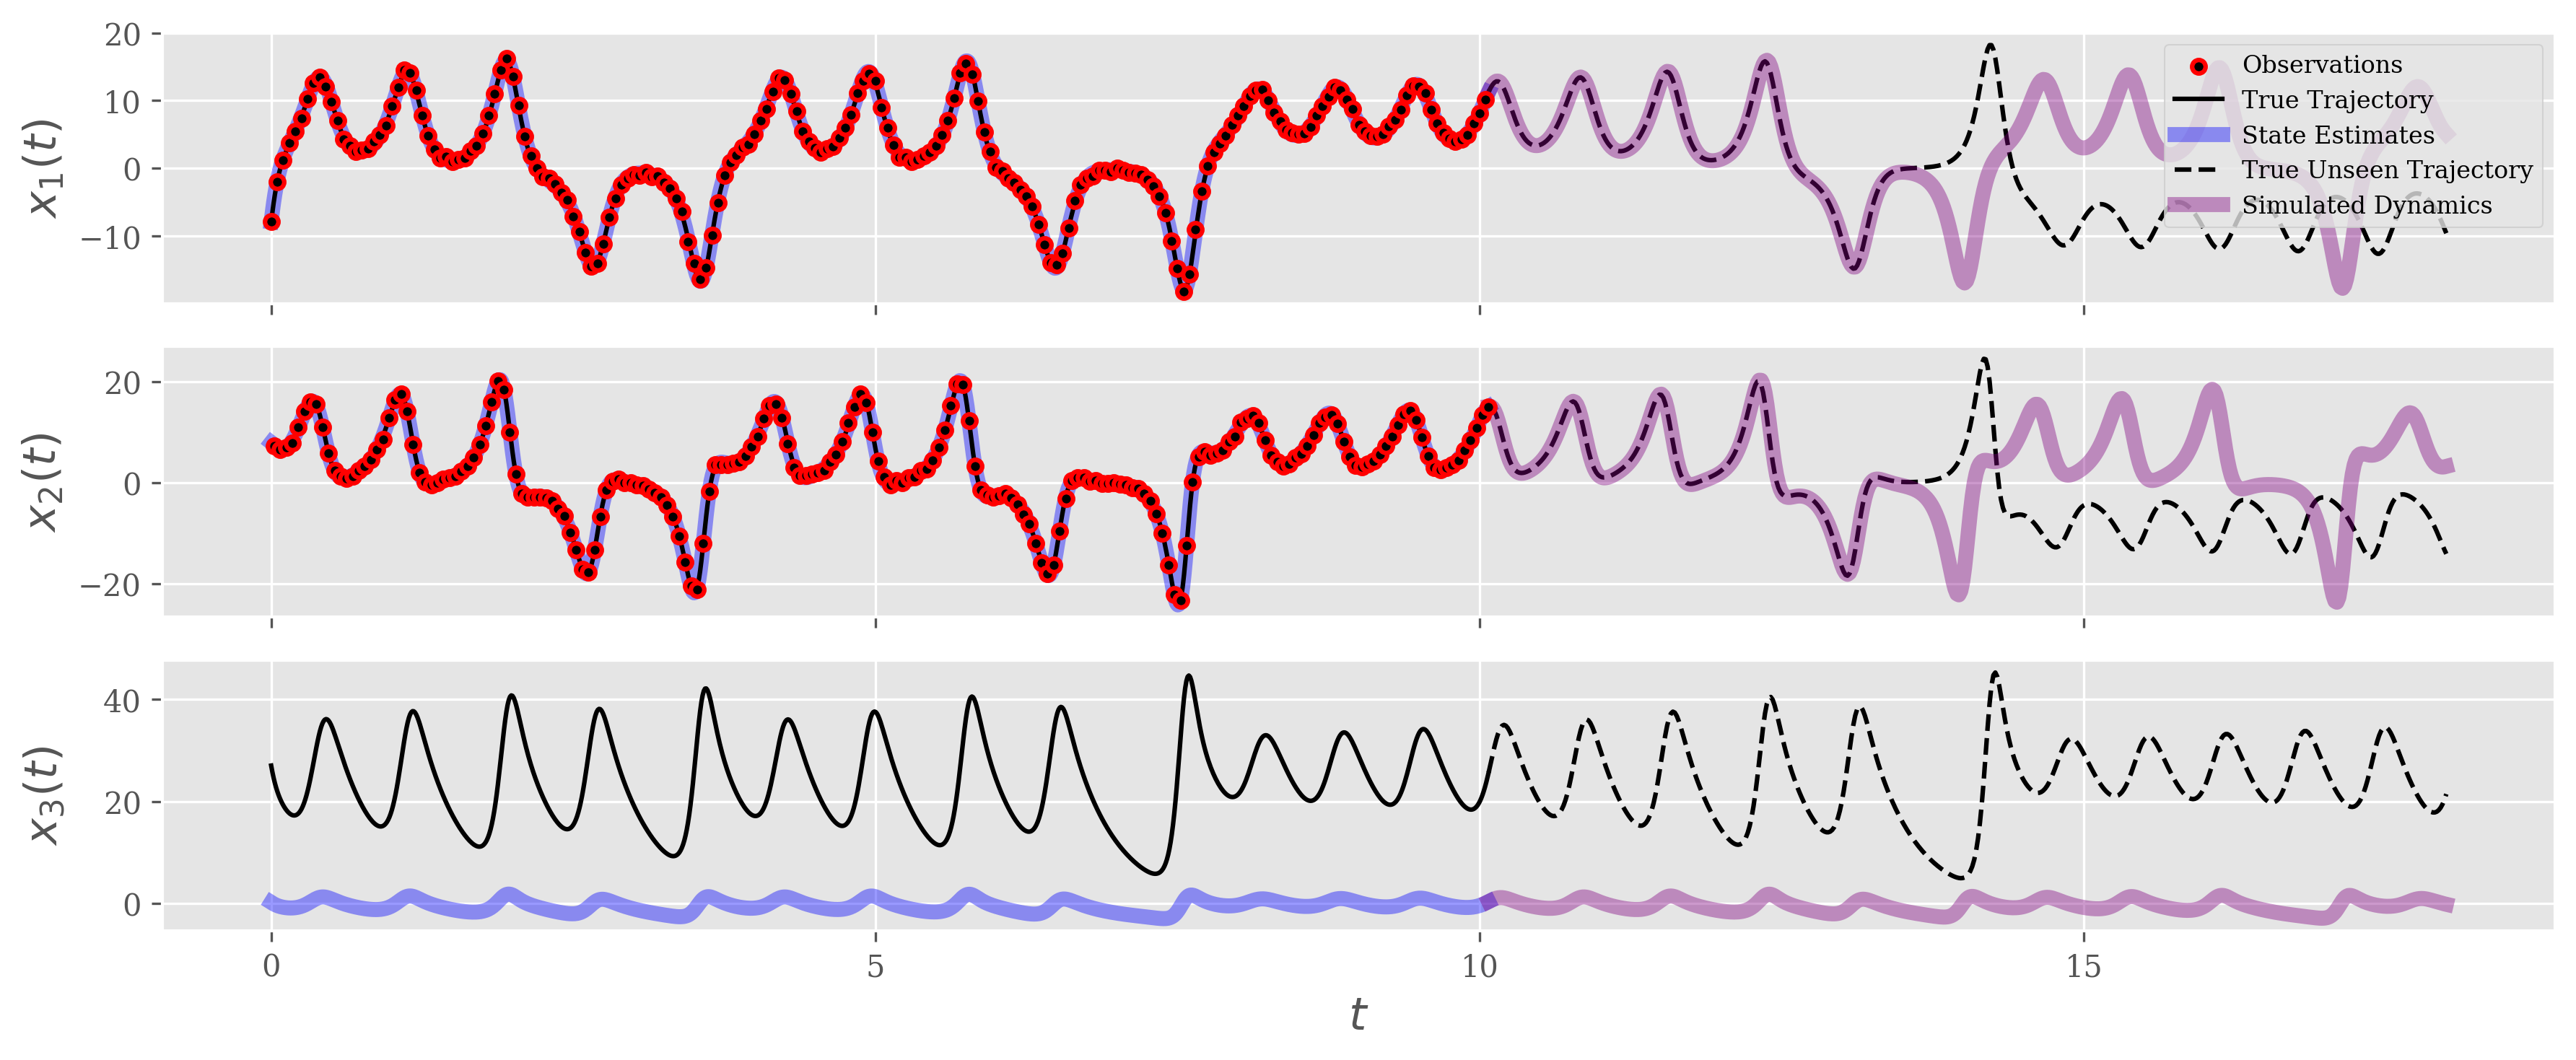

In [3]:
family='serif'
fig, ax = plt.subplots(3,1, figsize=(12,5),sharex=True,dpi=300)
ylabels = [r"$x_1(t)$", r"$x_2(t)$",r"$x_3(t)$"]



for dim in range(3):
    obs_index = jnp.where(jnp.argmax(measurement_vecs,axis=1) == dim)    
    ax[dim].scatter(
        t_train[obs_index], y_obs[obs_index],facecolors='black',edgecolors='red',lw=1.5, label='Observations',s=20,zorder=3)
    
    ax[dim].plot(t_fine, x_true[:,dim], label='True Trajectory',c='black',zorder=2)
    ax[dim].plot(t_fine, x_pred[:,dim], label='State Estimates', linestyle='-',c='blue', alpha=0.4,lw=5,zorder=1)

    # extension 
    ax[dim].plot(t_extend,x_true_extend[:,dim], c='black', linestyle='--', label='True Unseen Trajectory')    

    ax[dim].plot(t_extend,x_sim_extend[:,dim],c='purple',alpha=0.4, lw=5,linestyle='-',label='Simulated Dynamics')

    ax[dim].grid(True)
    if dim==2:
        ax[dim].set_ylabel(ylabels[dim], size=15, family=family,labelpad=12)
    else:
        ax[dim].set_ylabel(ylabels[dim], size=15, family=family,)
    if dim==0:
        ax[dim].legend(prop={'family':family,'size':8})
    if dim == 2:
        ax[dim].set_xlabel(r"$t$",size=15, family=family)
# plt.suptitle("Lorenz ", family=family,size=20)
# if savefigs:
ax[2].set_xticks([0,5,10,15])
plt.tight_layout()
plt.savefig(f"lorenz_unobserved.pdf")
# plt.savefig(f"figures/lorenz_unobserved.png")

plt.show()


In [15]:
# new_grid = jnp.linspace(9.5,40,5000)
# new_x = jax.vmap(sol.evaluate)(new_grid)
# plt.plot(new_x[:,0],new_x[:,1],c='black')